In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Format output of data frame. 
pd.set_option("precision", 4)
pd.set_option('display.max_columns', None)

### Data Preperation

The data is loaded into a pandas data frame and scaled using min-max scaling. Then the data is split into a training and testing set with 80% in the training set and 20% in the testing set. 

In [ ]:
# Read datasets into pandas data frames. 
wp = pd.read_csv('../data/pump_train_final_reduced.csv')

# Split attributes from target class
wp_target = wp.iloc[:,-1]
wp = wp.iloc[:,:-1]

In [ ]:
wp_dum = pd.get_dummies(wp)

# Review table as dummies
wp_dum

,gps_height,population,public_meeting,permit,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,1390.0000,109.000,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1399.0000,280.000,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,686.0000,250.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,263.0000,58.000,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,668.2972,200.875,1.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50374,540.0000,210.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
50375,351.0000,89.000,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
50376,1210.0000,125.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
50377,1212.0000,56.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
# Scale data using min-max scaling.
scaler = MinMaxScaler()
scaler.fit(wp_dum)
wp_dum = scaler.transform(wp_dum)

In [ ]:
wp_train, wp_test, wp_target_train, wp_target_test = train_test_split(wp_dum, wp_target, test_size=0.2, random_state=210)

### Functions

The following functions will be used throughout the KNN analysis that follows.

The runModel function initialized and fits the KNN model. It then makes predictions for the training and testing set, then calculates their corresponding accuracies. The predictions and accuracies for each set are returned. 

In [ ]:
def runModel(train, test, target_train, target_test, model): 
    """Returns predicted values for training and testing set, along with the model's accruacy for both."""
    
    # Initialize and fit clustering model
    mdl = model
    mdl.fit(train, target_train)    
    predTrain = mdl.predict(train)
    predTest = mdl.predict(test)
    
    trainAcc = accuracy_score(target_train, predTrain)
    testAcc = accuracy_score(target_test, predTest)
    
    return predTrain, predTest, trainAcc, testAcc

The runPCAModel performs PCA transformation keeping the amount of variance specified by the user as an input parameter. The transformed data is used in the runModel function.

In [ ]:
def runPCAModel(train, test, target_train, target_test, varCaptured, model): 
    """Returns the results of KNN using PCA transformed data and the number 
    of components required to caputure the inputted amount of variance.
    varCaptured is in decimal form to specify the amount of the data's variance the components capture. 
    """
    
    pca = PCA(n_components=None)
    
    # Initialize PCA keeping all components and fit to data. 
    pca = PCA(n_components=None)
    pca.fit(train)
    
    # Find number of components that obtain 95% of variance
    cumVar = pca.explained_variance_ratio_.cumsum().round(decimals=2)
    i = 0
    while True:
        if cumVar[i] >= varCaptured:  # True if at least varCaptured of the variance is captured
            numComp = i + 1  # Component number is index plus 1. 
            break
        i += 1
    
    # Rerun PCA analysis and transformations keeping only three components. 
    pca = PCA(n_components=numComp)
    pca.fit(train)
    train_PCA = pca.transform(train)
    test_PCA = pca.transform(test)
    
    # Call runClusteringModel function with PCA transformed data.
    predTrain, predTest, trainAcc, testAcc = runModel(train_PCA, test_PCA, target_train, target_test, model)
    return predTrain, predTest, trainAcc, testAcc, numComp

The printKNNStats function prints the accuracy of each set and calculates the difference. It also prints the classification report and produces a graph of the confusion matrix. 

In [ ]:
def printKNNStats(trainAcc, testAcc, wp_target_test, predTest):
    """Prints KNN results and confusion matrix."""
    print('The training set accuracy is equal to ' + str(round(trainAcc*100,2)) + '%.')
    print('The testing set accuracy is equal to ' + str(round(testAcc*100,2)) + '%.')
    print('The difference is ' + str(round((trainAcc-testAcc)*100,2)) + '%.\n')
    
    print(classification_report(wp_target_test, predTest))
    cm = confusion_matrix(wp_target_test, predTest)
    
    fig, ax = plt.subplots(figsize=(5.75, 5.75))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix - Test', fontsize=18)
    ax.xaxis.set_ticks_position("bottom")
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1,2])
    ax.set_xticklabels(['functional','functional needs repair', 'non functional'])
    ax.set_yticklabels(['functional','functional needs repair', 'non functional'])
    plt.show()
       
    return

The graphResults function graphs the results of tuning a hyperparameter. 

In [ ]:
def graphResults(x, TrainAcc, TestAcc, hyperparameter):
    """Produce graph for tuning nearest neighbors parameters."""
    
    # Create graph with number of K on x-axis and measures on y-axes.
    fig,ax = plt.subplots()
    
    # Formatting Y-axis on left side of plot 
    ax.plot(x, TrainAcc, color='blue', marker='o', label='Training Accuracy')
    ax.plot(x, TestAcc, color='red', marker='o', label='Testing Accuracy')
    ax.set_xlabel(hyperparameter,fontsize=14)
    ax.set_ylabel("Accuracy",fontsize=14)
    plt.title('Number of Neighbors vs Accuracy')
    # Formatting the legend and displaying plot
    ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
    plt.show()

### KNN Analysis

#### Model with default parameters

The training set accuracy is equal to 81.07%.
The testing set accuracy is equal to 75.6%.
The difference is 5.48%.

                         precision    recall  f1-score   support

             functional       0.76      0.87      0.81      5610
functional needs repair       0.43      0.20      0.28       734
         non functional       0.79      0.69      0.73      3732

               accuracy                           0.76     10076
              macro avg       0.66      0.59      0.61     10076
           weighted avg       0.74      0.76      0.74     10076



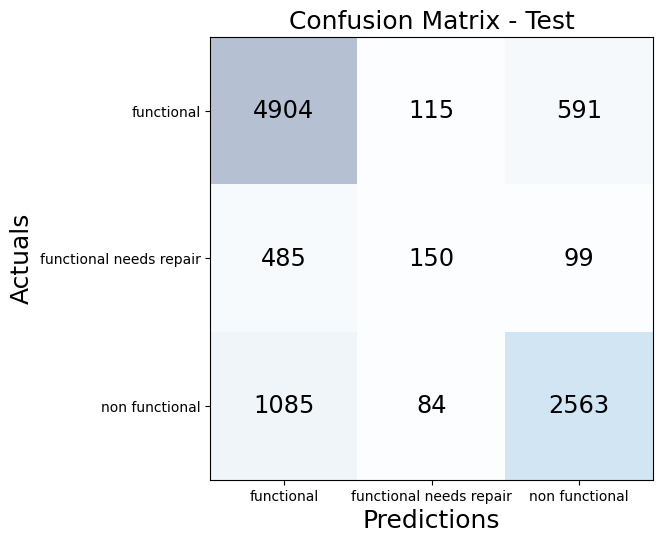


The testing set's balanced accuracy is 58.84%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier())
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

A KNN model using the defaul parameters is fitted as a baseline. 

### GridSearch Model

In [ ]:
# Performing grid search using all the training data to find best values for hyper-parameters.
neightbors = np.arange(3,12,2)
weights = ['uniform', 'distance']
gridDict = {'n_neighbors': neightbors, 'weights': weights}
grid = GridSearchCV(KNeighborsClassifier(), gridDict, n_jobs=-1)
grid.fit(wp_train, wp_target_train)
print(grid.best_params_) 

{'n_neighbors': 11, 'weights': 'distance'}


The training set accuracy is equal to 94.9%.
The testing set accuracy is equal to 76.26%.
The difference is 18.64%.

                         precision    recall  f1-score   support

             functional       0.77      0.87      0.82      5610
functional needs repair       0.44      0.23      0.30       734
         non functional       0.79      0.71      0.75      3732

               accuracy                           0.76     10076
              macro avg       0.67      0.60      0.62     10076
           weighted avg       0.75      0.76      0.75     10076



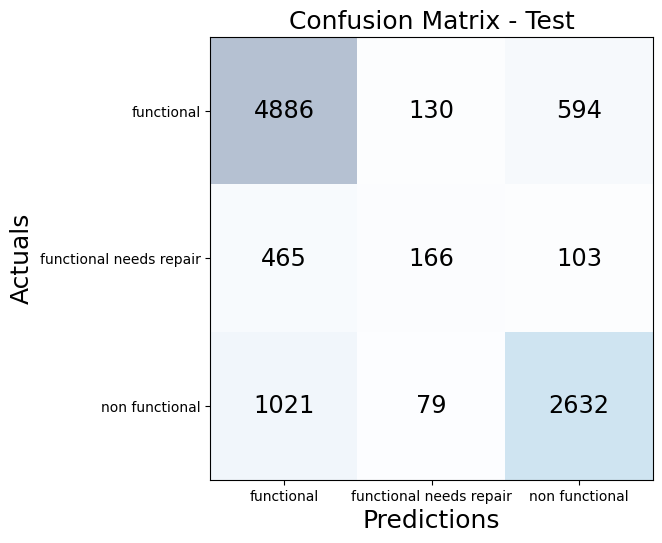


The testing set's balanced accuracy is 60.08%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 11, weights = 'distance'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The preceding model overfits the data and does not significantly improve the testing set results relative to the default model.

### Distance weighting testing

The training set accuracy is equal to 94.79%.
The testing set accuracy is equal to 75.03%.
The difference is 19.76%.

                         precision    recall  f1-score   support

             functional       0.77      0.84      0.80      5610
functional needs repair       0.38      0.25      0.30       734
         non functional       0.77      0.71      0.74      3732

               accuracy                           0.75     10076
              macro avg       0.64      0.60      0.61     10076
           weighted avg       0.74      0.75      0.74     10076



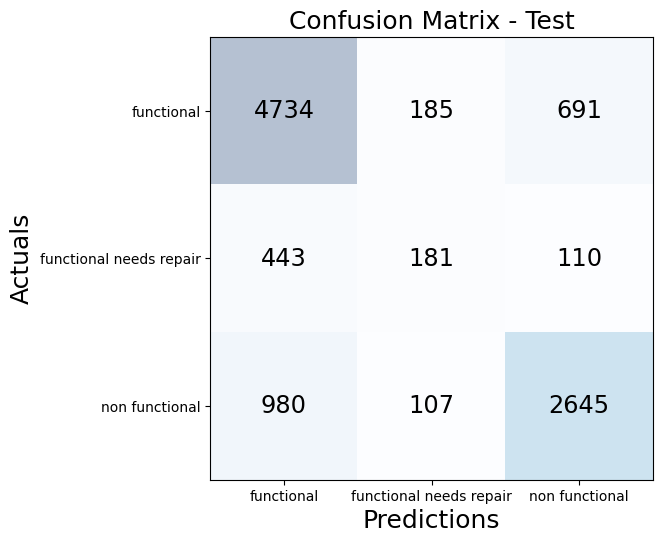


The testing set's balanced accuracy is 59.97%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(weights = 'distance'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The training set accuracy is equal to 95.04%.
The testing set accuracy is equal to 76.98%.
The difference is 18.05%.

                         precision    recall  f1-score   support

             functional       0.76      0.90      0.82      5610
functional needs repair       0.49      0.18      0.26       734
         non functional       0.81      0.69      0.75      3732

               accuracy                           0.77     10076
              macro avg       0.69      0.59      0.61     10076
           weighted avg       0.76      0.77      0.75     10076



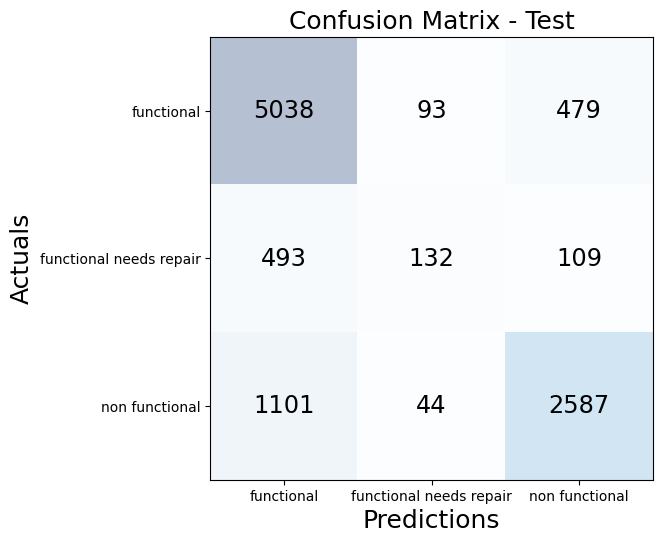


The testing set's balanced accuracy is 59.04%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 53, weights = 'distance'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Distance weighting overfits the model over a wide range of number of nearest neighbors.

### PCA Transformation testing

The training set accuracy is equal to 80.53%.
The testing set accuracy is equal to 74.75%.
The difference is 5.78%.

                         precision    recall  f1-score   support

             functional       0.75      0.86      0.80      5610
functional needs repair       0.40      0.20      0.26       734
         non functional       0.78      0.68      0.73      3732

               accuracy                           0.75     10076
              macro avg       0.64      0.58      0.60     10076
           weighted avg       0.74      0.75      0.74     10076



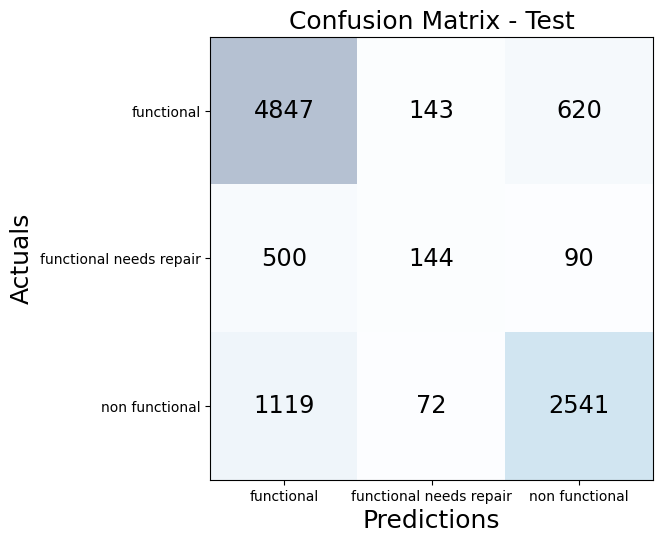

22 components were used to capture 95.0% of the data's variance.

The testing set's balanced accuracy is 58.03%.


In [ ]:
varCaptured = .95
predTrain, predTest, trainAcc, testAcc, numComp = runPCAModel(wp_train, wp_test, wp_target_train, wp_target_test, varCaptured, KNeighborsClassifier())
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '% of the data\'s variance.')
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

PCA transformed data using default parameters performed almost the same, but slightly worst than the non-PCA transformed data. 

### Metrics testing

The training set accuracy is equal to 80.95%.
The testing set accuracy is equal to 75.45%.
The difference is 5.5%.

                         precision    recall  f1-score   support

             functional       0.76      0.87      0.81      5610
functional needs repair       0.46      0.20      0.28       734
         non functional       0.78      0.69      0.73      3732

               accuracy                           0.75     10076
              macro avg       0.67      0.59      0.61     10076
           weighted avg       0.74      0.75      0.74     10076



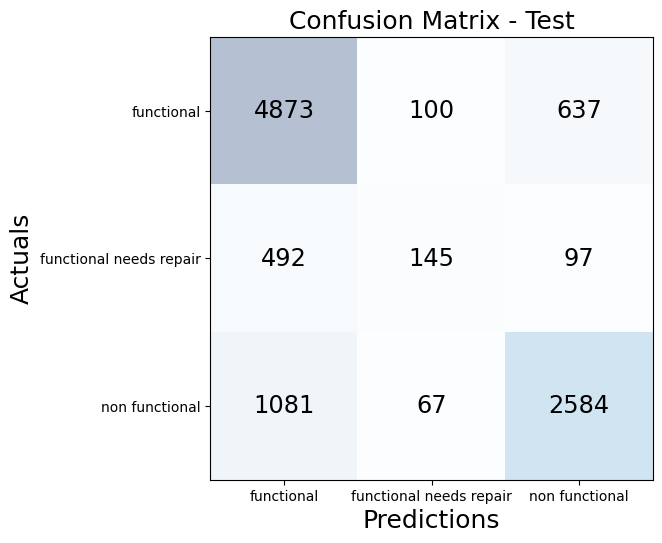


The testing set's balanced accuracy is 58.62%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(metric = 'manhattan'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Using the manhattan distance performs slightly worst on the testing set overall. However, it correctly classified non-function water pumps more correctly than the default model. It performed worst than the default model at correctly classifying functional and functional needs repair water pumps. 

The training set accuracy is equal to 79.6%.
The testing set accuracy is equal to 73.46%.
The difference is 6.14%.

                         precision    recall  f1-score   support

             functional       0.73      0.87      0.79      5610
functional needs repair       0.36      0.14      0.20       734
         non functional       0.77      0.65      0.71      3732

               accuracy                           0.73     10076
              macro avg       0.62      0.55      0.57     10076
           weighted avg       0.72      0.73      0.72     10076



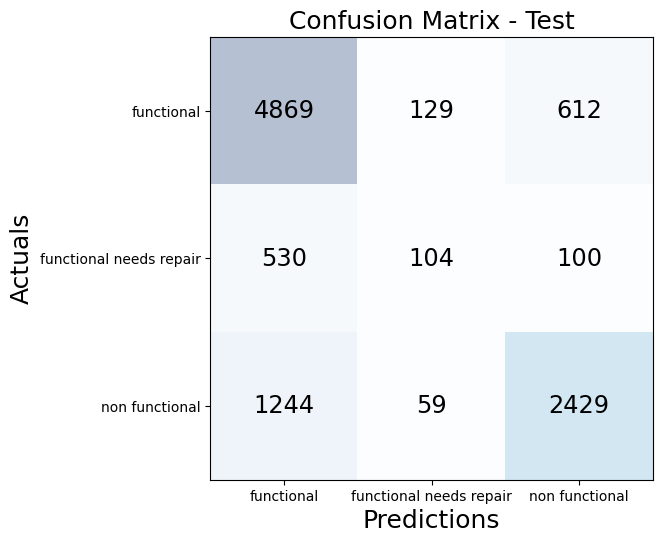


The testing set's balanced accuracy is 55.35%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(metric='hamming'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Using the hamming distance performed worst than the default model. 

The training set accuracy is equal to 81.1%.
The testing set accuracy is equal to 75.8%.
The difference is 5.3%.

                         precision    recall  f1-score   support

             functional       0.76      0.88      0.81      5610
functional needs repair       0.45      0.19      0.27       734
         non functional       0.79      0.69      0.74      3732

               accuracy                           0.76     10076
              macro avg       0.67      0.59      0.61     10076
           weighted avg       0.75      0.76      0.74     10076



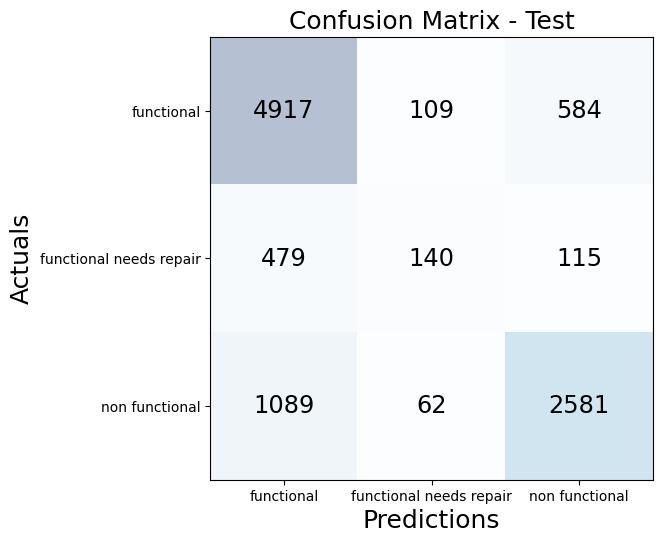


The testing set's balanced accuracy is 58.63%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(metric='cosine'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Using the cosine distance did better at classifying functional and non functional water pumps, but worst as functional needs repair. Unless correctly classifying functional needs repair is favored over the other two classes, this classifier is better than the default model. 

### Testing different algorithms

The training set accuracy is equal to 80.87%.
The testing set accuracy is equal to 75.34%.
The difference is 5.53%.

                         precision    recall  f1-score   support

             functional       0.76      0.87      0.81      5610
functional needs repair       0.43      0.19      0.27       734
         non functional       0.78      0.69      0.73      3732

               accuracy                           0.75     10076
              macro avg       0.66      0.58      0.60     10076
           weighted avg       0.74      0.75      0.74     10076



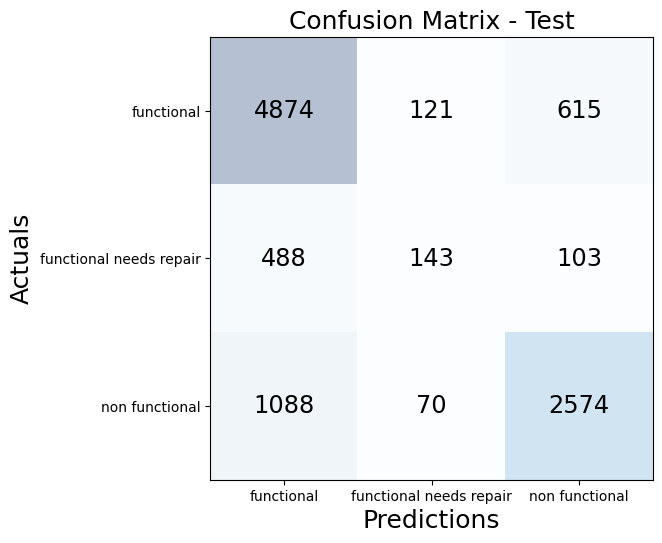


The testing set's balanced accuracy is 58.44%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(algorithm='ball_tree'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The training set accuracy is equal to 80.87%.
The testing set accuracy is equal to 75.32%.
The difference is 5.55%.

                         precision    recall  f1-score   support

             functional       0.76      0.87      0.81      5610
functional needs repair       0.43      0.19      0.27       734
         non functional       0.78      0.69      0.73      3732

               accuracy                           0.75     10076
              macro avg       0.65      0.58      0.60     10076
           weighted avg       0.74      0.75      0.74     10076



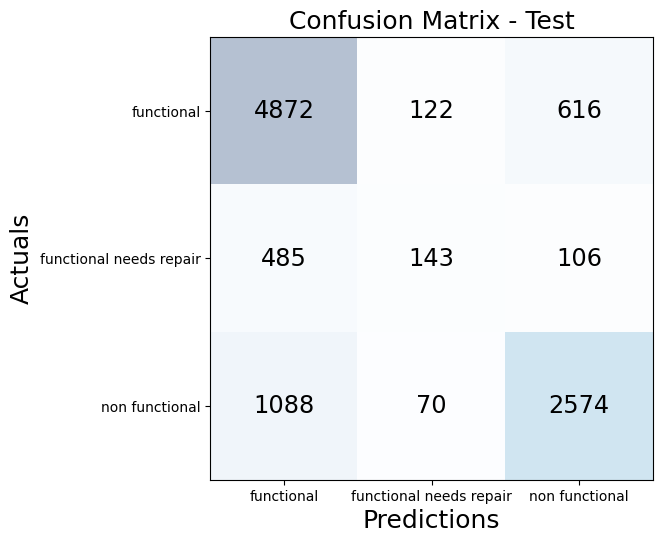


The testing set's balanced accuracy is 58.43%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(algorithm='kd_tree'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The ball_tree and kd_tree algorithim exhibited very similar results. They did not perform as well as the classifier using the cosine distance, but but was better than the default model at classifing non functional water pumps. 

The training set accuracy is equal to 81.07%.
The testing set accuracy is equal to 75.6%.
The difference is 5.48%.

                         precision    recall  f1-score   support

             functional       0.76      0.87      0.81      5610
functional needs repair       0.43      0.20      0.28       734
         non functional       0.79      0.69      0.73      3732

               accuracy                           0.76     10076
              macro avg       0.66      0.59      0.61     10076
           weighted avg       0.74      0.76      0.74     10076



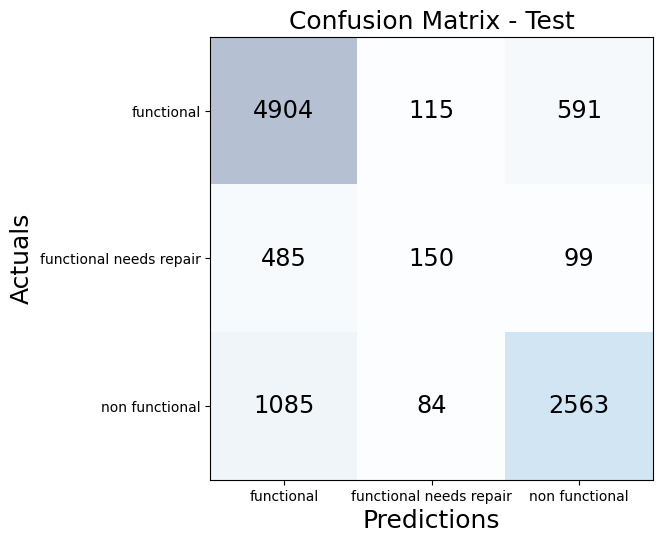


The testing set's balanced accuracy is 58.84%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(algorithm='brute'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The brute algorithm return the same results as the default model. 

### Testing values of number of neighbors

#### Using default parameters while changing number of nearest neighbors

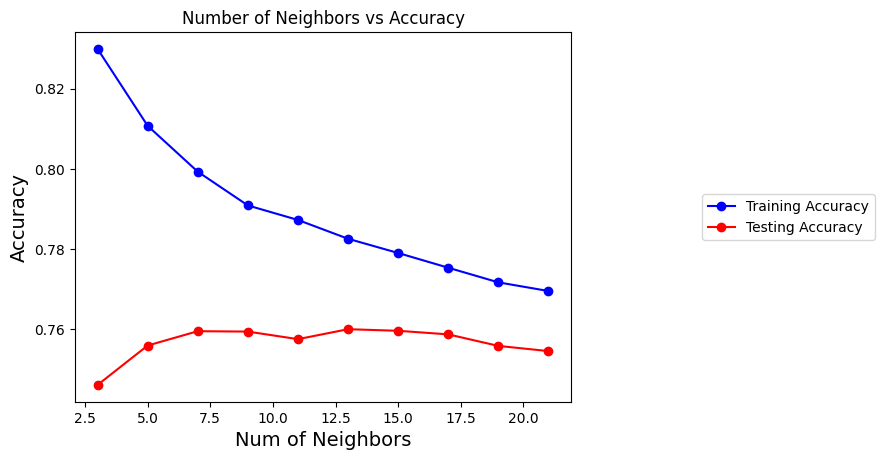

In [ ]:
# X-axis values and those to be tested for k
x = np.arange(3, 22, 2)

# placeholders for evaluation measure scores.
TrainAcc = []
TestAcc = []


# Test different values for nearest neighbors with default model parameters.
for n in x:
    predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = n))
    TrainAcc.append(trainAcc)
    TestAcc.append(testAcc)
    
graphResults(x, TrainAcc, TestAcc, 'Num of Neighbors')

The training set accuracy is equal to 78.26%.
The testing set accuracy is equal to 76.0%.
The difference is 2.25%.

                         precision    recall  f1-score   support

             functional       0.75      0.91      0.82      5610
functional needs repair       0.51      0.13      0.21       734
         non functional       0.81      0.67      0.73      3732

               accuracy                           0.76     10076
              macro avg       0.69      0.57      0.58     10076
           weighted avg       0.75      0.76      0.74     10076



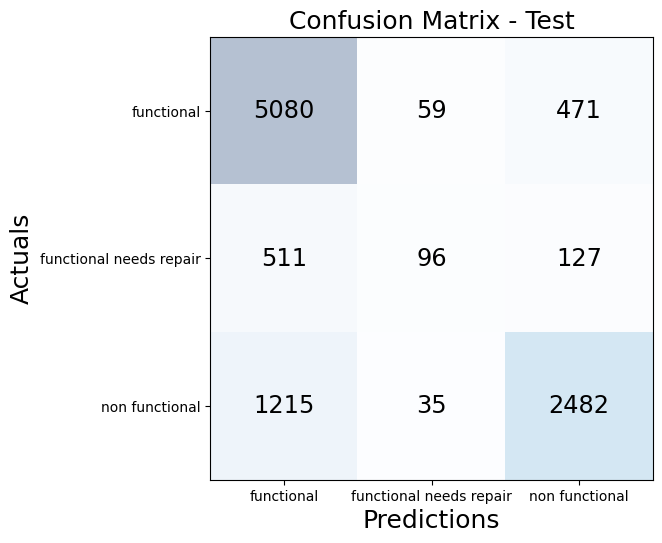


The testing set's balanced accuracy is 56.71%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 13))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The model using 13 neighbors classified more objects as functional. It classified functional water pumps correctly more times than the default and cosine models but at the cost of increasingly misclassifying the other two water pump labels. 

The training set accuracy is equal to 77.54%.
The testing set accuracy is equal to 75.87%.
The difference is 1.66%.

                         precision    recall  f1-score   support

             functional       0.75      0.90      0.82      5610
functional needs repair       0.51      0.13      0.21       734
         non functional       0.80      0.67      0.73      3732

               accuracy                           0.76     10076
              macro avg       0.69      0.57      0.58     10076
           weighted avg       0.75      0.76      0.74     10076



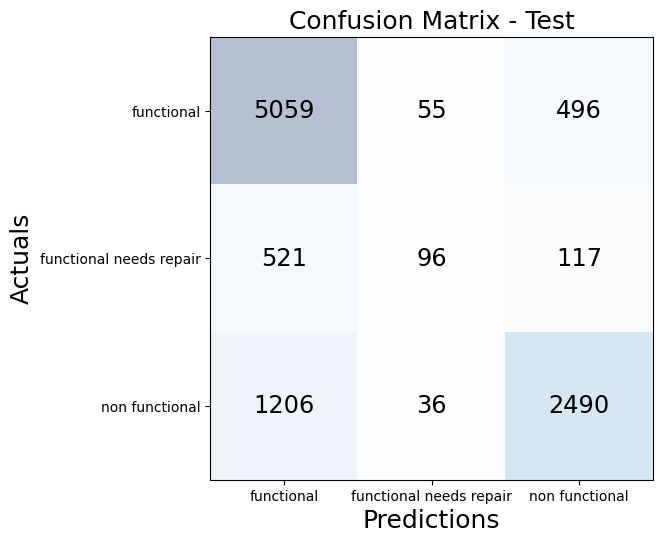


The testing set's balanced accuracy is 56.66%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 17))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Using 17 nearest neighbors did slightly better at classifing non functinoal water pumps than using 13 nearest neighbors. However, it performed worst at classifying functional water pumps. 

In [ ]:
#### Using default parameters with PCA transformed data while changing number of nearest neighbors

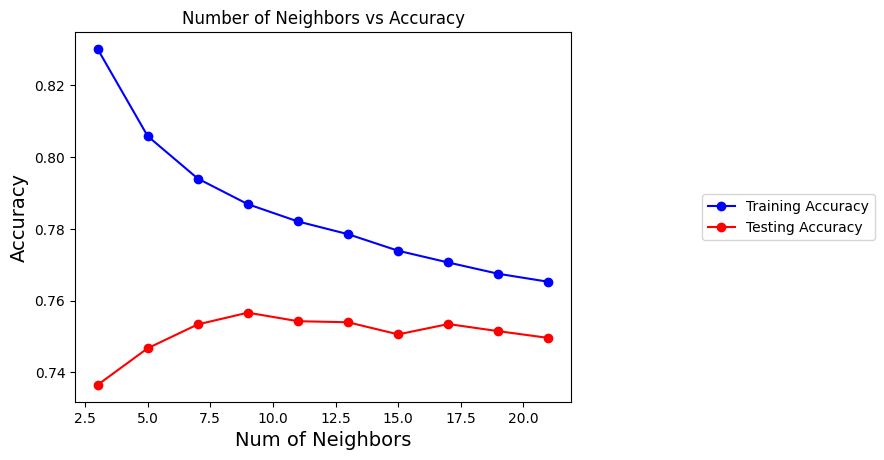

In [ ]:
# X-axis values and those to be tested for k
x = np.arange(3, 22, 2)

# placeholders for evaluation measure scores.
TrainAcc = []
TestAcc = []

varCaptured = .95

# Test different values for nearest neighbors with PCA transformed data.
for n in x:
    predTrain, predTest, trainAcc, testAcc, numComp = runPCAModel(wp_train, wp_test, wp_target_train, wp_target_test, varCaptured, KNeighborsClassifier(n_neighbors = n))
    TrainAcc.append(trainAcc)
    TestAcc.append(testAcc)
    
graphResults(x, TrainAcc, TestAcc, 'Num of Neighbors')

The training set accuracy is equal to 77.82%.
The testing set accuracy is equal to 75.5%.
The difference is 2.32%.

                         precision    recall  f1-score   support

             functional       0.74      0.90      0.81      5610
functional needs repair       0.46      0.11      0.18       734
         non functional       0.79      0.67      0.73      3732

               accuracy                           0.75     10076
              macro avg       0.67      0.56      0.57     10076
           weighted avg       0.74      0.75      0.73     10076



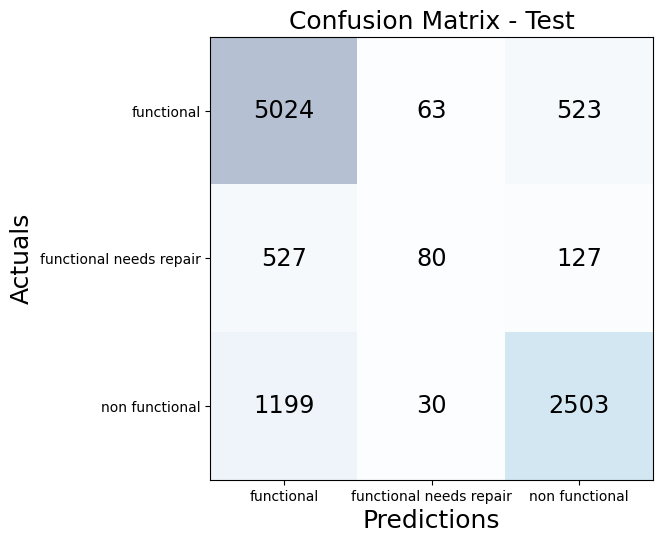

22 components were used to capture 95.0% of the data's variance.

The testing set's balanced accuracy is 55.84%.


In [ ]:
varCaptured = .95
predTrain, predTest, trainAcc, testAcc, numComp = runPCAModel(wp_train, wp_test, wp_target_train, wp_target_test, varCaptured, KNeighborsClassifier(n_neighbors = 13))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '% of the data\'s variance.')
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The training set accuracy is equal to 77.03%.
The testing set accuracy is equal to 75.39%.
The difference is 1.64%.

                         precision    recall  f1-score   support

             functional       0.74      0.90      0.81      5610
functional needs repair       0.48      0.12      0.19       734
         non functional       0.80      0.66      0.72      3732

               accuracy                           0.75     10076
              macro avg       0.67      0.56      0.58     10076
           weighted avg       0.74      0.75      0.73     10076



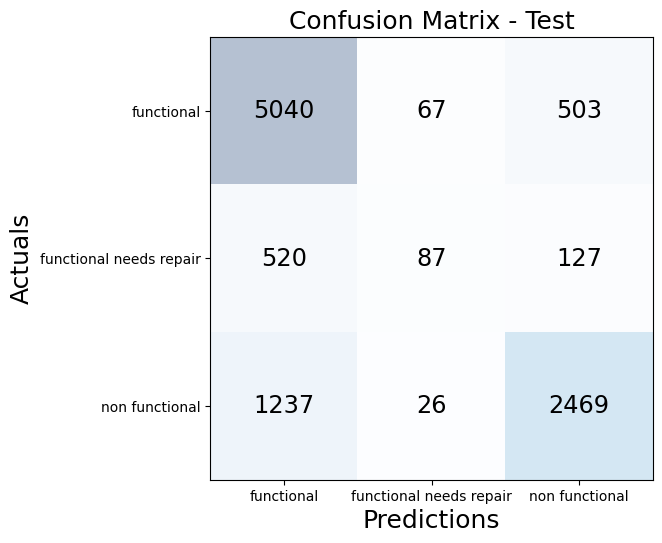

22 components were used to capture 95.0% of the data's variance.

The testing set's balanced accuracy is 55.95%.


In [ ]:
varCaptured = .95
predTrain, predTest, trainAcc, testAcc, numComp = runPCAModel(wp_train, wp_test, wp_target_train, wp_target_test, varCaptured, KNeighborsClassifier(n_neighbors = 17))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '% of the data\'s variance.')
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Using the PCA transformed data increases the recall for functional water pumps, but decreases the precision. Depending on the application of the model, this could be good or bad.

#### Using cosine distance while changing number of nearest neighbors

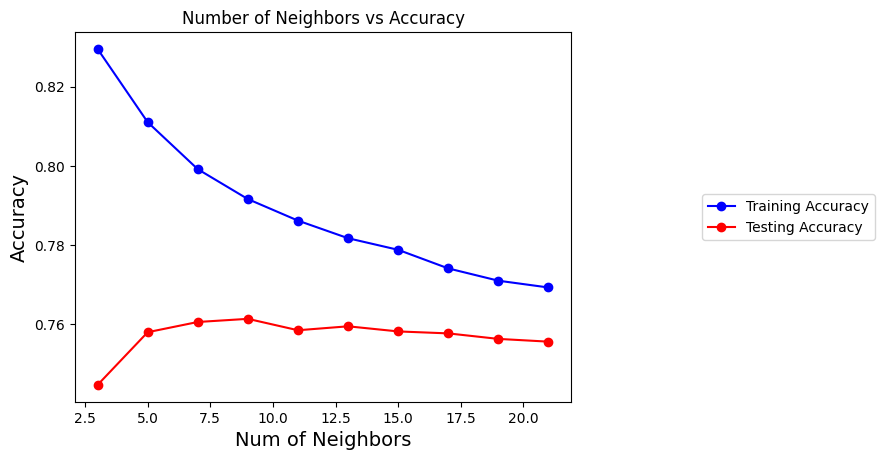

In [ ]:
# X-axis values and those to be tested for k
x = np.arange(3, 22, 2)

# placeholders for evaluation measure scores.
TrainAcc = []
TestAcc = []


# Test different values for nearest neighbors with cosine distance.
for n in x:
    predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = n, metric='cosine'))
    TrainAcc.append(trainAcc)
    TestAcc.append(testAcc)
    
graphResults(x, TrainAcc, TestAcc, 'Num of Neighbors')

The training set accuracy is equal to 79.16%.
The testing set accuracy is equal to 76.14%.
The difference is 3.02%.

                         precision    recall  f1-score   support

             functional       0.75      0.89      0.82      5610
functional needs repair       0.48      0.16      0.24       734
         non functional       0.80      0.68      0.74      3732

               accuracy                           0.76     10076
              macro avg       0.68      0.58      0.60     10076
           weighted avg       0.75      0.76      0.75     10076



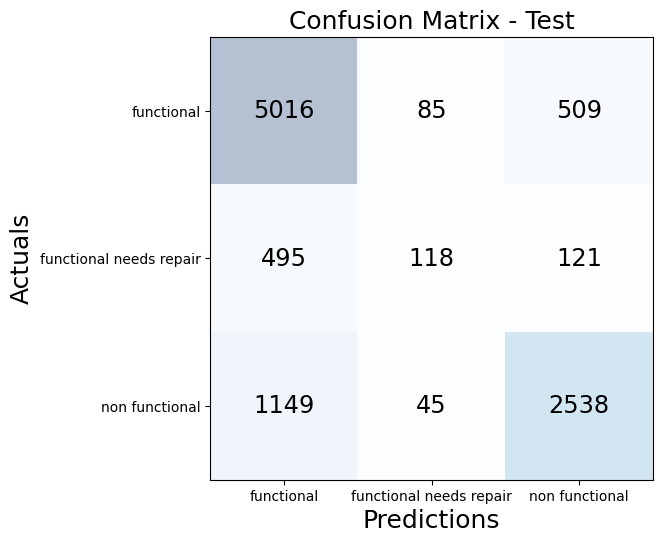


The testing set's balanced accuracy is 57.83%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 9, metric='cosine'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The training set accuracy is equal to 78.18%.
The testing set accuracy is equal to 75.95%.
The difference is 2.22%.

                         precision    recall  f1-score   support

             functional       0.75      0.90      0.82      5610
functional needs repair       0.51      0.13      0.20       734
         non functional       0.80      0.67      0.73      3732

               accuracy                           0.76     10076
              macro avg       0.69      0.57      0.58     10076
           weighted avg       0.75      0.76      0.74     10076



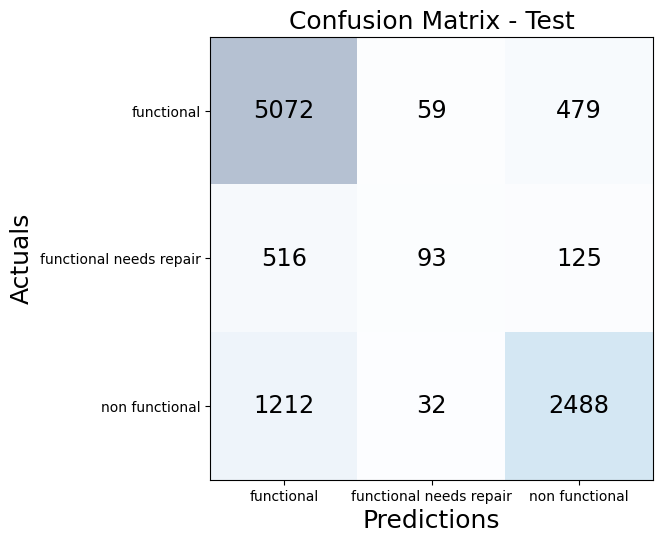


The testing set's balanced accuracy is 56.58%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 13, metric='cosine'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The training set accuracy is equal to 79.92%.
The testing set accuracy is equal to 76.06%.
The difference is 3.86%.

                         precision    recall  f1-score   support

             functional       0.75      0.89      0.82      5610
functional needs repair       0.49      0.18      0.26       734
         non functional       0.79      0.69      0.74      3732

               accuracy                           0.76     10076
              macro avg       0.68      0.58      0.60     10076
           weighted avg       0.75      0.76      0.75     10076



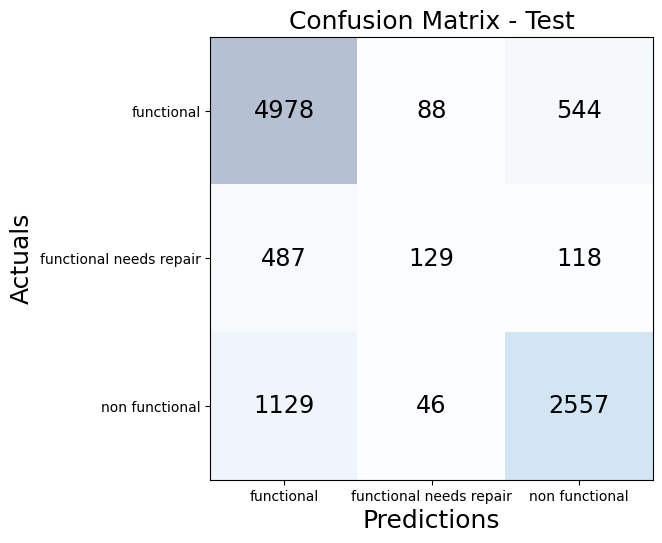


The testing set's balanced accuracy is 58.27%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 7, metric='cosine'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Increasing the number of nearest neighbors using the cosine metric experienced similar results as it did using the euclidean metric. More water pumps were classified as a function with that class's recall increasing but at the expense of higher misclassification of the other two water pump types. 

### Test stratified random sampling

In [ ]:
wp_train, wp_test, wp_target_train, wp_target_test = train_test_split(wp_dum, wp_target, test_size=0.2, random_state=210, stratify=wp_target)

#### Using default parameters

The training set accuracy is equal to 80.9%.
The testing set accuracy is equal to 74.96%.
The difference is 5.94%.

                         precision    recall  f1-score   support

             functional       0.75      0.87      0.81      5592
functional needs repair       0.39      0.21      0.28       707
         non functional       0.79      0.68      0.73      3777

               accuracy                           0.75     10076
              macro avg       0.64      0.59      0.60     10076
           weighted avg       0.74      0.75      0.74     10076



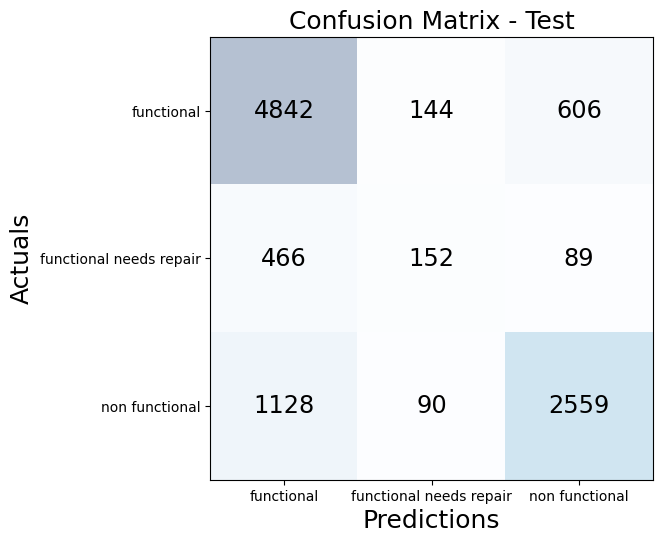


The testing set's balanced accuracy is 58.61%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier())
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

#### Distance weighting

The training set accuracy is equal to 94.65%.
The testing set accuracy is equal to 74.44%.
The difference is 20.2%.

                         precision    recall  f1-score   support

             functional       0.77      0.84      0.80      5592
functional needs repair       0.35      0.25      0.29       707
         non functional       0.77      0.70      0.73      3777

               accuracy                           0.74     10076
              macro avg       0.63      0.60      0.61     10076
           weighted avg       0.74      0.74      0.74     10076



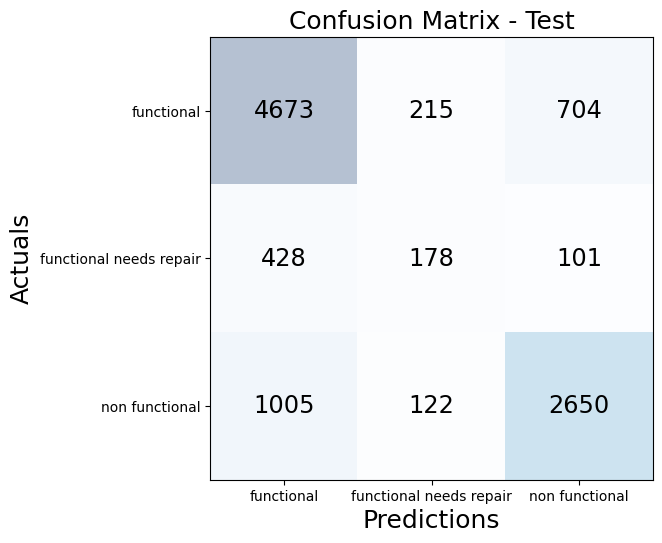


The testing set's balanced accuracy is 59.63%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(weights = 'distance'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

#### Using default parameters while changing number of nearest neighbors

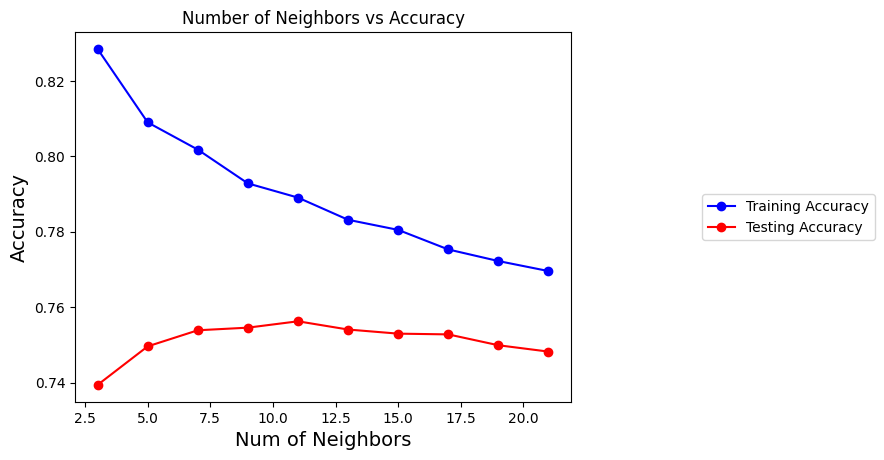

In [ ]:
# X-axis values and those to be tested for k
x = np.arange(3, 22, 2)

# placeholders for evaluation measure scores.
TrainAcc = []
TestAcc = []


# Test different values for nearest neighbors with default model parameters.
for n in x:
    predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = n))
    TrainAcc.append(trainAcc)
    TestAcc.append(testAcc)
    
graphResults(x, TrainAcc, TestAcc, 'Num of Neighbors')

The training set accuracy is equal to 78.9%.
The testing set accuracy is equal to 75.63%.
The difference is 3.28%.

                         precision    recall  f1-score   support

             functional       0.75      0.89      0.81      5592
functional needs repair       0.47      0.17      0.25       707
         non functional       0.80      0.67      0.73      3777

               accuracy                           0.76     10076
              macro avg       0.67      0.58      0.60     10076
           weighted avg       0.75      0.76      0.74     10076



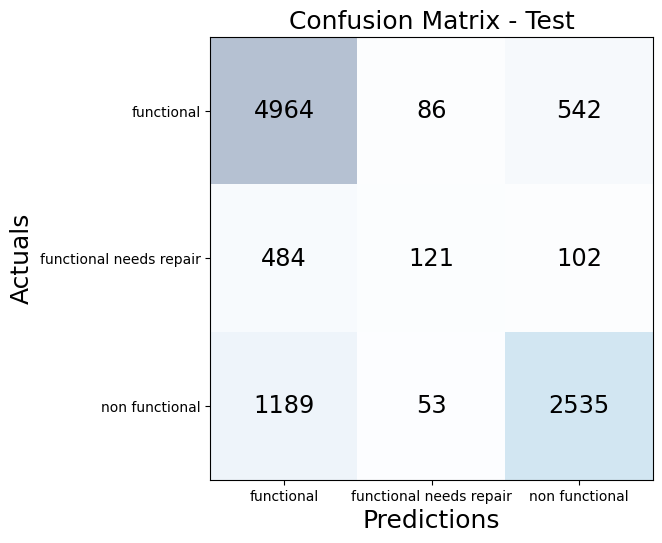

In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 11))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)

#### Using default parameters with PCA transformed data while changing number of nearest neighbors

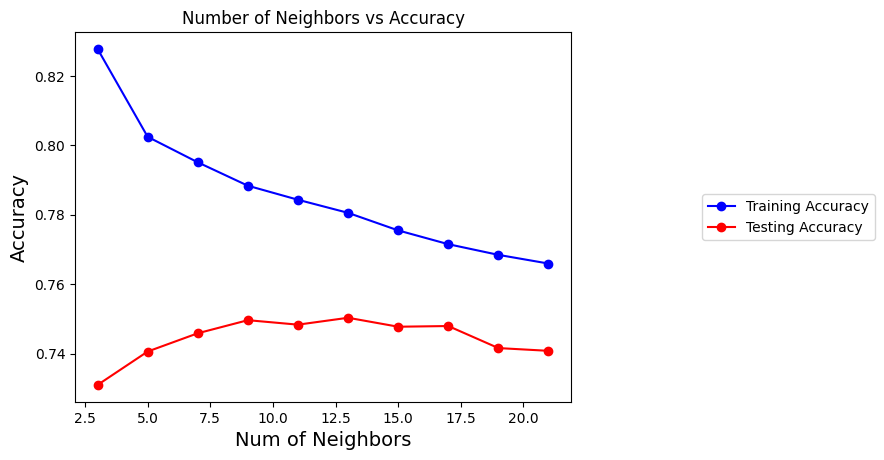

In [ ]:
# X-axis values and those to be tested for k
x = np.arange(3, 22, 2)

# placeholders for evaluation measure scores.
TrainAcc = []
TestAcc = []

varCaptured = .95

# Test different values for nearest neighbors with PCA transformed data.
for n in x:
    predTrain, predTest, trainAcc, testAcc, numComp = runPCAModel(wp_train, wp_test, wp_target_train, wp_target_test, varCaptured, KNeighborsClassifier(n_neighbors = n))
    TrainAcc.append(trainAcc)
    TestAcc.append(testAcc)
    
graphResults(x, TrainAcc, TestAcc, 'Num of Neighbors')

The training set accuracy is equal to 78.77%.
The testing set accuracy is equal to 74.8%.
The difference is 3.96%.

                         precision    recall  f1-score   support

             functional       0.74      0.88      0.81      5592
functional needs repair       0.40      0.16      0.23       707
         non functional       0.79      0.67      0.72      3777

               accuracy                           0.75     10076
              macro avg       0.65      0.57      0.59     10076
           weighted avg       0.74      0.75      0.73     10076



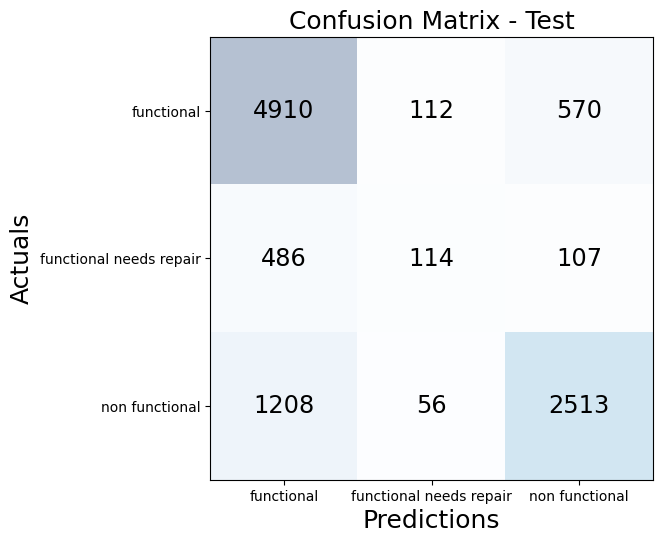

22 components were used to capture 95.0% of the data's variance.

The testing set's balanced accuracy is 56.82%.


In [ ]:
varCaptured = .95
predTrain, predTest, trainAcc, testAcc, numComp = runPCAModel(wp_train, wp_test, wp_target_train, wp_target_test, varCaptured, KNeighborsClassifier(n_neighbors = 9))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '% of the data\'s variance.')
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The training set accuracy is equal to 78.03%.
The testing set accuracy is equal to 74.95%.
The difference is 3.08%.

                         precision    recall  f1-score   support

             functional       0.74      0.88      0.81      5592
functional needs repair       0.44      0.14      0.22       707
         non functional       0.79      0.67      0.72      3777

               accuracy                           0.75     10076
              macro avg       0.66      0.56      0.58     10076
           weighted avg       0.74      0.75      0.73     10076



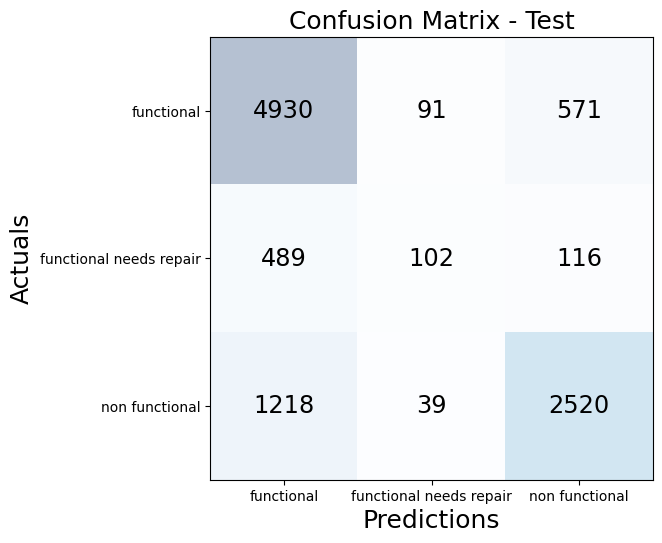

22 components were used to capture 95.0% of the data's variance.

The testing set's balanced accuracy is 56.44%.


In [ ]:
varCaptured = .95
predTrain, predTest, trainAcc, testAcc, numComp = runPCAModel(wp_train, wp_test, wp_target_train, wp_target_test, varCaptured, KNeighborsClassifier(n_neighbors = 13))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '% of the data\'s variance.')
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

#### Using cosine distance while changing number of nearest neighbors

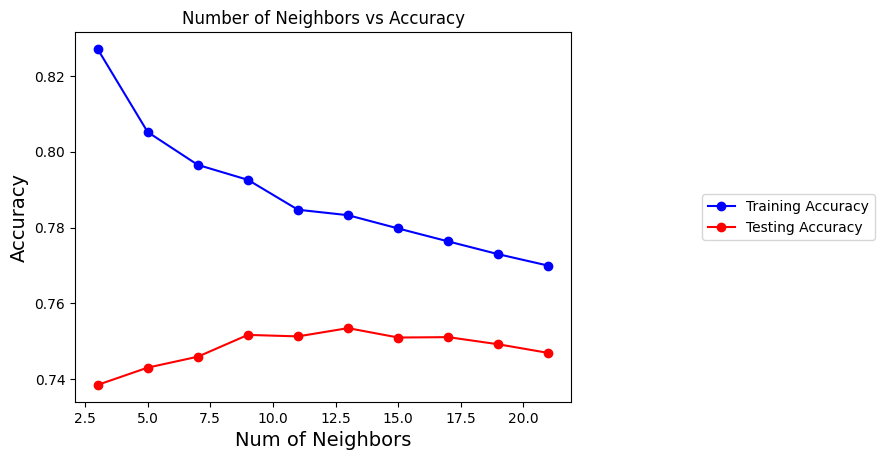

In [ ]:
# X-axis values and those to be tested for k
x = np.arange(3, 22, 2)

# placeholders for evaluation measure scores.
TrainAcc = []
TestAcc = []


# Test different values for nearest neighbors with cosine distance.
for n in x:
    predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = n, metric='cosine'))
    TrainAcc.append(trainAcc)
    TestAcc.append(testAcc)
    
graphResults(x, TrainAcc, TestAcc, 'Num of Neighbors')

The training set accuracy is equal to 78.33%.
The testing set accuracy is equal to 75.35%.
The difference is 2.98%.

                         precision    recall  f1-score   support

             functional       0.75      0.89      0.81      5592
functional needs repair       0.46      0.16      0.24       707
         non functional       0.79      0.67      0.72      3777

               accuracy                           0.75     10076
              macro avg       0.66      0.57      0.59     10076
           weighted avg       0.74      0.75      0.74     10076



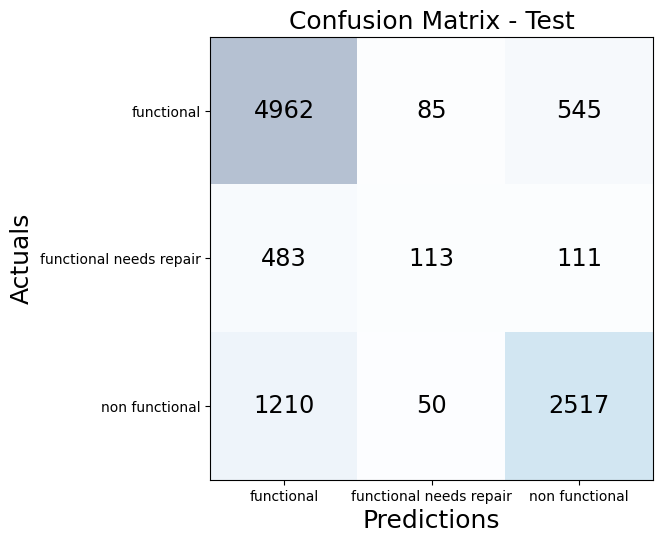


The testing set's balanced accuracy is 57.12%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(n_neighbors = 13, metric='cosine'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

The training set accuracy is equal to 80.52%.
The testing set accuracy is equal to 74.31%.
The difference is 6.21%.

                         precision    recall  f1-score   support

             functional       0.75      0.86      0.80      5592
functional needs repair       0.35      0.20      0.25       707
         non functional       0.79      0.67      0.72      3777

               accuracy                           0.74     10076
              macro avg       0.63      0.58      0.59     10076
           weighted avg       0.73      0.74      0.73     10076



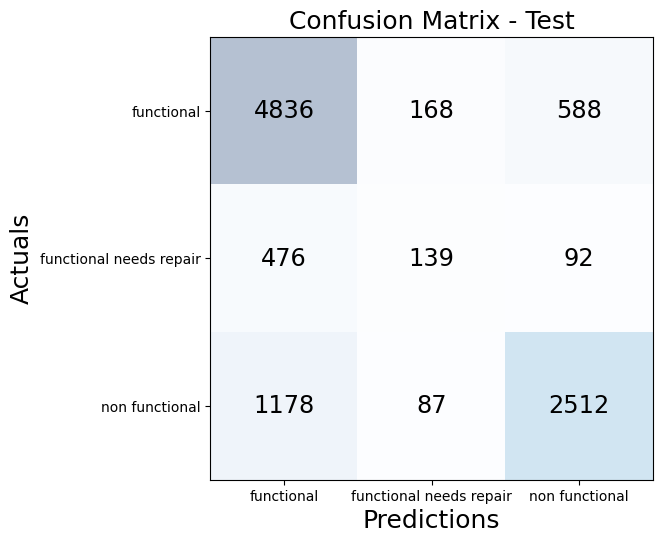


The testing set's balanced accuracy is 57.55%.


In [ ]:
predTrain, predTest, trainAcc, testAcc = runModel(wp_train, wp_test, wp_target_train, wp_target_test, KNeighborsClassifier(metric='cosine'))
printKNNStats(trainAcc, testAcc, wp_target_test, predTest)
testBalAcc = balanced_accuracy_score(wp_target_test, predTest)
print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')

Stratisfied sampling did not significantly impact the results of the model compared to simple random sampling.

In [ ]:
import pickle 

knn_final = KNeighborsClassifier(metric='cosine')
knn_final = knn_final.fit(wp_train, wp_target_train)

# Write pickle
with open('knn_final.pkl', 'wb') as pickle_file:
    pickle.dump(knn_final, pickle_file)